# Basic Mechanisms

Here we implement two basic mechanisms for differentially private data analysis. The first is the Laplace mechanism, and the second is the Gaussian mechanism. Both mechanisms are based on the idea of adding noise to the data before releasing it.

First, lets create a synthetic dataset, which we will use to test our mechanisms.

In [1]:
import torch

N = 1000                # Number of records
K = 10                  # Number of features
X = torch.rand(N, K)    # Data
X

tensor([[0.8929, 0.3690, 0.7188,  ..., 0.6146, 0.8856, 0.5433],
        [0.7029, 0.2046, 0.5899,  ..., 0.3408, 0.3652, 0.2121],
        [0.2978, 0.7103, 0.2328,  ..., 0.8262, 0.1690, 0.3817],
        ...,
        [0.4219, 0.9580, 0.7470,  ..., 0.4380, 0.0022, 0.7373],
        [0.7244, 0.7782, 0.1396,  ..., 0.1575, 0.8302, 0.9062],
        [0.2815, 0.6724, 0.0678,  ..., 0.5069, 0.1926, 0.9870]])

Now, we define the function that we aim to privatize. In this case, we will use the sum of all the records in the dataset.

In [2]:
def sum_all(data):
    return data.sum(dim=0)

Let's see what the sum of the dataset is in the non-private setting:

In [3]:
sum_all(X)

tensor([499.9321, 499.0273, 490.0689, 492.0590, 512.1083, 519.6473, 496.4540,
        501.9817, 501.0992, 511.8332])

## Laplace Mechanism

The Laplace mechanism adds Laplace noise to the output before releasing it. The Laplace mechanism is defined as follows:

In [4]:
def lap_mech(data, func, sensitivity, epsilon):
    '''Laplace mechanism for making a function differentially private

    Args:
        data: Dataset to which the function is applied
        func: Function to apply to the data
        sensitivity: L1 Sensitivity of the function
        epsilon: Privacy parameter

    Returns:
        A differentially private version of the function's output
    '''
    return func(data) + torch.distributions.Laplace(loc=0, scale=sensitivity/epsilon).sample()

Let's test the Laplace mechanism on our `sum_all` function. As each element of our dataset is between 0 and 1, adding or removing a record from the dataset will change the sum by at most 1 at each dimension. Having K dimensions, the L1 sensitivity of `sum_all` is thus K.

In [5]:
senitivity = K
epsilon = 1
lap_mech(X, sum_all, senitivity, epsilon)

tensor([494.3449, 493.4400, 484.4817, 486.4718, 506.5211, 514.0601, 490.8668,
        496.3945, 495.5120, 506.2460])

## Gaussian Mechanism

The Gaussian mechanism adds Gaussian noise to the output before releasing it. The Gaussian mechanism is defined as follows:

In [6]:
import math

def gaussian_mech(data, func, sensitivity, epsilon, delta):
    '''Gaussian mechanism for making a function differentially private

    Args:
        data: Dataset to which the function is applied
        func: Function to apply to the data
        sensitivity: L2 Sensitivity of the function
        epsilon: Privacy parameter
        delta: Failure probability

    Returns:
        A differentially private version of the function's output
    '''
    sigma = sensitivity * math.sqrt(2 * math.log(1.25 / delta)) / epsilon
    return torch.distributions.Normal(loc=func(data), scale=sigma).sample()

Let's test the Gaussian mechanism on our `sum_all` function. As each element of our dataset is between 0 and 1, adding or removing a record from the dataset will change the sum by at most 1 at each dimension. Having K dimensions, the L2 sensitivity of sum_all is $\sqrt{K}$.

In [7]:
senstivity = math.sqrt(K)
epsilon = 1
delta = 1e-5
gaussian_mech(X, sum_all, senstivity, epsilon, delta)

tensor([492.5835, 501.4439, 463.6763, 497.3094, 494.8914, 541.1539, 510.3267,
        506.2322, 518.0912, 537.5726])

The Gaussian mechanism is more accurate than the Laplace mechanism in higher dimensions, as the L2 sensitivity is smaller than the L1 sensitivity. Here, we empirically verify this by comparing the mean squared error of the output of the two mechanisms w.r.t the non-private output for varying dimensions while fixing the privacy budget.

<AxesSubplot: xlabel='Dimension', ylabel='MSE'>

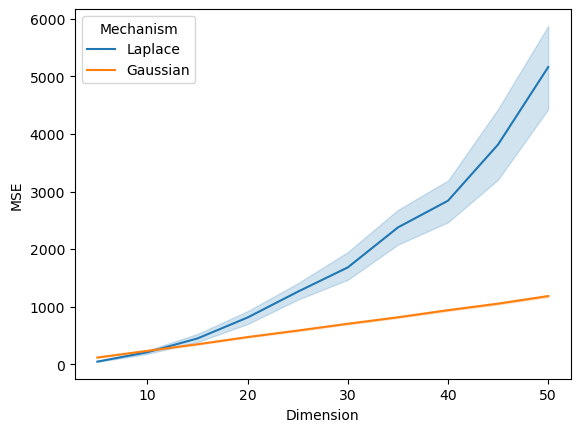

In [8]:
import pandas as pd
import seaborn as sns


# fixed parameters
N = 1000
epsilon = 1
delta = 1e-5

results = []    # list of results

for K in range(5, 51, 5):
    X = torch.rand(N, K)
    non_priv_sum = sum_all(X)
    num_trials = 1000

    for t in range(num_trials):
        priv_sum_lap = lap_mech(X, sum_all, sensitivity=K, epsilon=epsilon)
        mse_lap = (non_priv_sum - priv_sum_lap).pow(2).mean().item()
        results.append({'Dimension': K, 'MSE': mse_lap, 'Mechanism': 'Laplace'})

        priv_sum_gauss = gaussian_mech(X, sum_all, sensitivity=math.sqrt(K), epsilon=epsilon, delta=delta)
        mse_gauss = (non_priv_sum - priv_sum_gauss).pow(2).mean().item()
        results.append({'Dimension': K, 'MSE': mse_gauss, 'Mechanism': 'Gaussian'})

df = pd.DataFrame(results)
sns.lineplot(data=df, x='Dimension', y='MSE', hue='Mechanism')

We observe that under (1, 1e-5)-DP, the Gaussian mechanism is more accurate than the Laplace mechanism for K > 12.

# Privacy Accounting using AutoDP

[AutoDP](https://github.com/yuxiangw/autodp) is a tool for accounting the privacy cost of differentially private mechanisms. In this section, we will show how to use AutoDP to compute the privacy cost of the DP-SGD algorithm.

We can use `pip` to install AutoDP directly from GitHub:

In [ ]:
! pip install git+https://github.com/yuxiangw/autodp

In [9]:
from autodp.mechanism_zoo import ExactGaussianMechanism
from autodp.transformer_zoo import Composition, AmplificationBySampling

Let's first fix the parameters of the DP-SGD algorithm:

In [10]:
N = 10000                       # Number of data samples in the dataset
B = 64                          # Batch size
E = 100                         # Number of epochs
C = 1                           # Clipping threshold
sigma = 2                       # Noise standard deviation
q = B / N                       # Probability of sampling each data point
T = E * N // B                  # Total number of iterations

Now, we create the DP-SGD mechanism using AutoDP step by step. In DP-SGD, at each iteration, the Gaussian mechanism is applied to the sum of the clipped gradients:

In [11]:
gm = ExactGaussianMechanism(sigma=sigma / C)    # The sigma parameter in the ExactGaussianMechanism class is supposed to be the standard deviation
                                                #   of the noise devided by the L2 sensitivity (here the clipping threshold)

As we use mini-batch gradient descent with Batch size B, the about mechanism is applied to the sub-sampled batch instead of the whole dataset. To account for the sub-sampling, we apply the `AmplificationBySampling` transformer:

In [12]:
subsample = AmplificationBySampling(PoissonSampling=True)           # Poisson sampling means sub-sampling with replacement
subsampled_gm = subsample(gm, prob=q, improved_bound_flag=True)     # improved_bound_flag=True gives a tighter bound on the privacy loss

Finally, we compose the subsampled Gaussian mechanism over T iterations:

In [13]:
composition = Composition()
composed_subsampled_gm = composition([subsampled_gm], [T])

Now, we can compute the privacy cost (epsilon) of the DP-SGD algorithm given the `delta` parameter:

In [14]:
epsilon = composed_subsampled_gm.get_approxDP(delta=1e-5)
print(f'epsilon = {epsilon:.4f}')

epsilon = 1.8342


/remote/idiap.svm/temp.social02/sajadmanesh/conda/envs/progdp/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2769: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom


AutoDP offers a calibrator to calibrate the noise scale (or any other parameter) of a given mechanim (like DP-SGD) to achieve a desired privacy cost (epsilon). To this end, we first need to define a new class for our mechanism that inherits from AutoDP's `Mechanism` class, accepts a dictionary of parameters and an optional name as input, and creates the target mechanism based on the given parameters. Here, we define the following `NoisySGD` class for the DP-SGD algorithm:

In [15]:
from autodp.mechanism_zoo import Mechanism


class NoisySGD(Mechanism):
    def __init__(self, params, name='NoisySGD'):
        super().__init__()
        self.params = params    # parameters of the mechanism
        self.name = name        # name of the mechanism

        # Similar to before, we create the DP-SGD mechanism using params
        gm = ExactGaussianMechanism(sigma=params['sigma'] / params['C'])
        subsample = AmplificationBySampling(PoissonSampling=True)
        subsampled_gm = subsample(gm, prob=params['B']/params['N'], improved_bound_flag=True)
        composition = Composition()
        composed_subsampled_gm = composition([subsampled_gm], [params['E'] * params['N'] // params['B']])

        # This step is important. We need to set this class's privacy representation equal to composed_subsampled_gm
        self.set_all_representation(composed_subsampled_gm)

Let's test the `NoisySGD` class to see if it yields the same privacy cost as the DP-SGD mechanism we created above:

In [16]:
params = {'N': N, 'B': B, 'E': E, 'C': C, 'sigma': sigma}
noisy_sgd = NoisySGD(params)
epsilon = noisy_sgd.get_approxDP(delta=1e-5)
print(f'epsilon = {epsilon:.4f}')

epsilon = 1.8342


Now we use the calibrator to find the `sigma` parameter such that the DP-SGD algorithm achieves (3, 1e-5)-DP:

In [17]:
from autodp.calibrator_zoo import generalized_eps_delta_calibrator

calibrator = generalized_eps_delta_calibrator()
calibrated_noisy_sgd = calibrator(
    mech_class=NoisySGD,            # The target mechanism class
    eps=3,                          # Target epsilon value
    delta=1e-5,                     # Target delta value
    params=params,                  # Initial parameters of the mechanism
    para_name='sigma',              # The parameter to be calibrated
    bounds=[0, 10],                 # Bounds to seach for the optimal parameter
)

print(f'Calibrated sigma = {calibrated_noisy_sgd.params["sigma"]:.4f}')
epsilon = calibrated_noisy_sgd.get_approxDP(delta=1e-5)
print(f'epsilon = {epsilon:.4f}')

Calibrated sigma = 1.3902
epsilon = 3.0000


# Training ML models with DP using Opacus

[Opacus](http://opacus.ai) is a library for training PyTorch ML models with differential privacy. In this section, we show how to use Opacus to train a ResNet18 model on the CIFAR10 dataset. This tutorial is adapted from the [Opacus tutorial](https://opacus.ai/tutorials/building_image_classifier).

We can install Opacus using `pip`:

In [ ]:
! pip install opacus

Now, let's fix the hyper-parameters of the training process:

In [18]:
import warnings
warnings.simplefilter("ignore")

MAX_GRAD_NORM = 1.2     # Equivalent to the clipping threshold C
EPSILON = 50.0
DELTA = 1e-5
EPOCHS = 20
LR = 1e-3

There's another constraint we should be mindful of&mdash;memory. The DP-SGD algorithm works better with larger batch-sizes ([De et. al, 2022](http://arxiv.org/abs/2204.13650)). However, larger batch-sizes quickly exhaust the GPU memory as we need to compute per-sample gradients that requirs O(BATCH_SIZE * NUM_PARAMS) memory. 

To balance peak memory requirement and training performance, we will be using `BatchMemoryManager`. It separates the logical batch size (which defines how often the model is updated and how much DP noise is added), and a physical batch size (which defines how many samples we process at a time).

With BatchMemoryManager you will create your `DataLoader` with a logical batch size, and then provide the maximum physical batch size to the memory manager. This way, the memory manager will split the logical batch into multiple physical batches, and will process them one by one. Noise addition and model update will happen after each locagical batch.

In [19]:
BATCH_SIZE = 512
MAX_PHYSICAL_BATCH_SIZE = 128

## Data

Now, let's load the CIFAR10 dataset. Note that for the data loaders, we use the logical batch size `BATCH_SIZE` instead of the physical batch size `PHYSICAL_BATCH_SIZE`. The physical batch size will be handled by the `BatchMemoryManager` later.

In [20]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

DATA_ROOT = 'datasets/'

# These values, specific to the CIFAR10 dataset, are assumed to be known.
# If necessary, they can be computed with modest privacy budgets.
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD_DEV = (0.2023, 0.1994, 0.2010)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD_DEV),
])

train_dataset = CIFAR10(root=DATA_ROOT, train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)

test_dataset = CIFAR10(root=DATA_ROOT, train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## Model

We use the ResNet18 model from `torchvision`.

In [21]:
from torchvision import models

model = models.resnet18(num_classes=10)

Now, let’s check if the model is compatible with Opacus. Opacus does not support all types of Pytorch layers. To check if your model is compatible with the privacy engine, we have provided a util class to validate your model.

When you run the code below, you're presented with a list of errors, indicating which modules are incompatible.

In [22]:
from opacus.validators import ModuleValidator

errors = ModuleValidator.validate(model, strict=False)
errors[-5:]

[opacus.validators.errors.ShouldReplaceModuleError("BatchNorm cannot support training with differential privacy. The reason for it is that BatchNorm makes each sample's normalized value depend on its peers in a batch, ie the same sample x will get normalized to a different value depending on who else is on its batch. Privacy-wise, this means that we would have to put a privacy mechanism there too. While it can in principle be done, there are now multiple normalization layers that do not have this issue: LayerNorm, InstanceNorm and their generalization GroupNorm are all privacy-safe since they don't have this property.We offer utilities to automatically replace BatchNorms to GroupNorms and we will release pretrained models to help transition, such as GN-ResNet ie a ResNet using GroupNorm, pretrained on ImageNet"),
 opacus.validators.errors.ShouldReplaceModuleError("BatchNorm cannot support training with differential privacy. The reason for it is that BatchNorm makes each sample's normal

Let us modify the model to work with Opacus. From the output above, you can see that the BatchNorm layers are not supported because they compute the mean and variance across the batch, creating a dependency between samples in a batch, a privacy violation.

Recommended approach to deal with it is calling `ModuleValidator.fix(model)` - it tries to find the best replacement for incompatible modules. For example, for BatchNorm modules, it replaces them with GroupNorm.
You can see, that after this, no exception is raised

In [23]:
model = ModuleValidator.fix(model)
ModuleValidator.validate(model, strict=False)

[]

For maximal speed, we can check if CUDA is available and supported by the PyTorch installation. If GPU is available, set the `device` variable to your CUDA-compatible device. We can then transfer the neural network onto that device.

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

We then define our optimizer and loss function. Opacus’ privacy engine can attach to any (first-order) optimizer.  You can use your favorite&mdash;Adam, Adagrad, RMSprop&mdash;as long as it has an implementation derived from [torch.optim.Optimizer](https://pytorch.org/docs/stable/optim.html). In this tutorial, we're going to use [RMSprop](https://pytorch.org/docs/stable/optim.html).

In [25]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=LR)

## Prepare for Training

We will define a util function to calculate accuracy

In [26]:
def accuracy(preds, labels):
    return (preds == labels).mean()

We now attach the privacy engine initialized with the privacy hyperparameters defined earlier.

In [28]:
from opacus import PrivacyEngine

privacy_engine = PrivacyEngine()

model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
    module=model,
    optimizer=optimizer,
    data_loader=train_loader,
    epochs=EPOCHS,
    target_epsilon=EPSILON,
    target_delta=DELTA,
    max_grad_norm=MAX_GRAD_NORM,
)

print(f"Using sigma={optimizer.noise_multiplier}")


Using sigma=0.37197113037109375


We will then define our train function. This function will train the model for one epoch. Here we use the `BatchMemoryManager` to convert the data loader `train_loader` to a memory-safe data loader `memory_safe_data_loader`.

In [29]:
import numpy as np
from opacus.utils.batch_memory_manager import BatchMemoryManager


def train(model, train_loader, optimizer, epoch, device):
    model.train()
    criterion = nn.CrossEntropyLoss()

    losses = []
    top1_acc = []
    
    with BatchMemoryManager(
        data_loader=train_loader, 
        max_physical_batch_size=MAX_PHYSICAL_BATCH_SIZE, 
        optimizer=optimizer
    ) as memory_safe_data_loader:

        for i, (images, target) in enumerate(memory_safe_data_loader):   
            optimizer.zero_grad()
            images = images.to(device)
            target = target.to(device)

            # compute output
            output = model(images)
            loss = criterion(output, target)

            preds = np.argmax(output.detach().cpu().numpy(), axis=1)
            labels = target.detach().cpu().numpy()

            # measure accuracy and record loss
            acc = accuracy(preds, labels)

            losses.append(loss.item())
            top1_acc.append(acc)

            loss.backward()
            optimizer.step()

            if (i+1) % 200 == 0:
                epsilon = privacy_engine.get_epsilon(DELTA)
                print(
                    f"\tTrain Epoch: {epoch} \t"
                    f"Loss: {np.mean(losses):.6f} "
                    f"Acc@1: {np.mean(top1_acc) * 100:.6f} "
                    f"(ε = {epsilon:.2f}, δ = {DELTA})"
                )

Next, we will define our test function to validate our model on our test dataset. 

In [30]:
def test(model, test_loader, device):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    losses = []
    top1_acc = []

    with torch.no_grad():
        for images, target in test_loader:
            images = images.to(device)
            target = target.to(device)

            output = model(images)
            loss = criterion(output, target)
            preds = np.argmax(output.detach().cpu().numpy(), axis=1)
            labels = target.detach().cpu().numpy()
            acc = accuracy(preds, labels)

            losses.append(loss.item())
            top1_acc.append(acc)

    top1_avg = np.mean(top1_acc)

    print(
        f"\tTest set:"
        f"Loss: {np.mean(losses):.6f} "
        f"Acc: {top1_avg * 100:.6f} "
    )
    return np.mean(top1_acc)

## Train the network

In [ ]:
from tqdm.notebook import tqdm

for epoch in tqdm(range(EPOCHS), desc="Epoch", unit="epoch"):
    train(model, train_loader, optimizer, epoch + 1, device)

Epoch:   0%|          | 0/20 [00:00<?, ?epoch/s]

	Train Epoch: 1 	Loss: 2.845050 Acc@1: 14.203841 (ε = 12.21, δ = 1e-05)
	Train Epoch: 1 	Loss: 2.406651 Acc@1: 21.317973 (ε = 14.64, δ = 1e-05)
	Train Epoch: 2 	Loss: 1.771367 Acc@1: 38.408665 (ε = 16.79, δ = 1e-05)
	Train Epoch: 2 	Loss: 1.743804 Acc@1: 40.674049 (ε = 18.34, δ = 1e-05)
	Train Epoch: 3 	Loss: 1.727064 Acc@1: 45.659264 (ε = 19.92, δ = 1e-05)
	Train Epoch: 3 	Loss: 1.737521 Acc@1: 46.235221 (ε = 21.18, δ = 1e-05)
	Train Epoch: 4 	Loss: 1.719044 Acc@1: 49.438898 (ε = 22.61, δ = 1e-05)
	Train Epoch: 4 	Loss: 1.709199 Acc@1: 50.202448 (ε = 23.71, δ = 1e-05)
	Train Epoch: 5 	Loss: 1.705325 Acc@1: 52.530885 (ε = 24.89, δ = 1e-05)
	Train Epoch: 5 	Loss: 1.692694 Acc@1: 53.125161 (ε = 25.87, δ = 1e-05)
	Train Epoch: 6 	Loss: 1.687639 Acc@1: 54.461010 (ε = 27.04, δ = 1e-05)
	Train Epoch: 6 	Loss: 1.683238 Acc@1: 54.522643 (ε = 27.97, δ = 1e-05)
	Train Epoch: 7 	Loss: 1.692552 Acc@1: 55.212898 (ε = 29.05, δ = 1e-05)
	Train Epoch: 7 	Loss: 1.681146 Acc@1: 55.607673 (ε = 29.91, δ =

## Test the network on test data

In [ ]:
top1_acc = test(model, test_loader, device)

	Test set:Loss: 1.711833 Acc: 60.753676 
